In [22]:
import sys

sys.path.insert(0, "../")

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import torch
from tqdm import tqdm

from src.data.generate_datasets import BASE_ADVECTION_CONFIG as CONFIG, generate_advection_dataset
from src.training.advection.train import TRAIN_PARAMETERS, TEST_PARAMETERS

## Settings
We input where to store the generated images and what parameters we'll be using.


In [25]:
base_storage_path = Path("../data/advection")
results_path = Path("../results/advection")

In [26]:
print(CONFIG.initial_condition_params)

GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010]))


## Generate data
Use the parameters to generate the data.

In [27]:
stacked_train_datasets = generate_advection_dataset(TRAIN_PARAMETERS, base_storage_path=base_storage_path, return_stacked=True)
stacked_test_datasets = generate_advection_dataset(TEST_PARAMETERS, base_storage_path=base_storage_path, return_stacked=True)

train_dataset = torch.utils.data.TensorDataset(stacked_train_datasets)
test_dataset = torch.utils.data.TensorDataset(stacked_test_datasets)

GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) tensor(0.0030)
GaussianParamSet(mu=tensor([0.2030]), sigma=tensor([0.0010]))
GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) tensor(0.0060)
GaussianParamSet(mu=tensor([0.2060]), sigma=tensor([0.0010]))
GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) tensor(0.0090)
GaussianParamSet(mu=tensor([0.2090]), sigma=tensor([0.0010]))
GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) tensor(0.0121)
GaussianParamSet(mu=tensor([0.2121]), sigma=tensor([0.0010]))
GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) GaussianParamSet(mu=tensor([0.2000]), sigma=tensor([0.0010])) tensor(0.0151)
GaussianParamSet(mu=tensor([0.2151]), sigma=tensor([0.001

## Retrieve configurations

During training we don't need these configurations from the datasets, but it's useful for plotting stuff.

In [28]:
domain = torch.linspace(CONFIG.xmin, CONFIG.xmax, CONFIG.Nx)
time = torch.linspace(0, CONFIG.T, CONFIG.Nt)

In [29]:
loss_functional = torch.nn.MSELoss()

In [30]:
TTx, XX = torch.meshgrid(
    [time, domain],
    indexing="ij",
)

## Plotting a snapshot

In this, we plot the waterfall plots associated to the three runs inside this dataset.

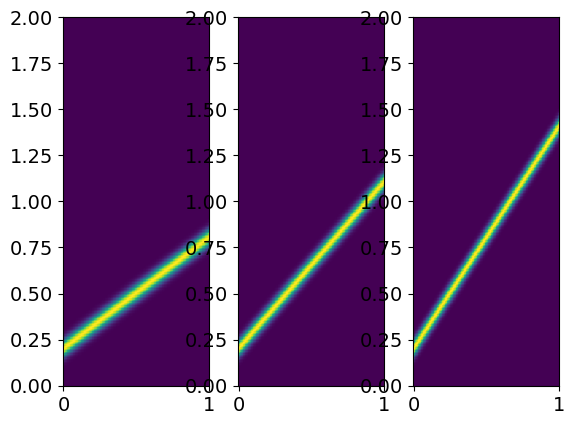

In [31]:
fig, axs = plt.subplots(1, 3)
for i in range(len(TRAIN_PARAMETERS)):
    axs[i].pcolormesh(TTx, XX, stacked_train_datasets[i * CONFIG.Nt : (i + 1) * CONFIG.Nt].data.detach())

## Plotting a snapshot

In this, we plot the snapshot matrix associated to the first run together with its singular values.

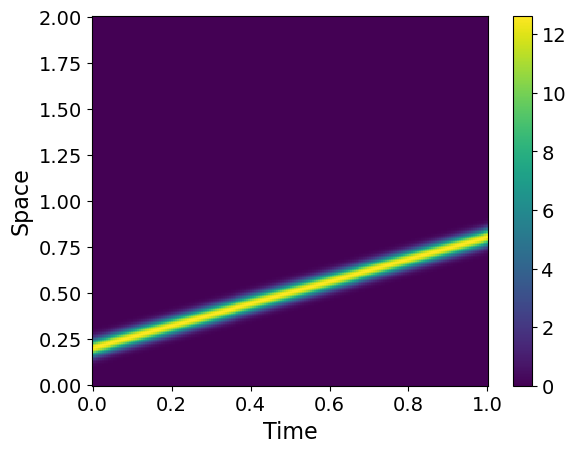

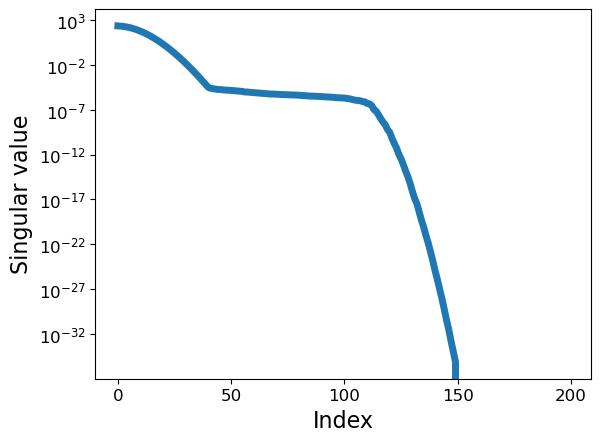

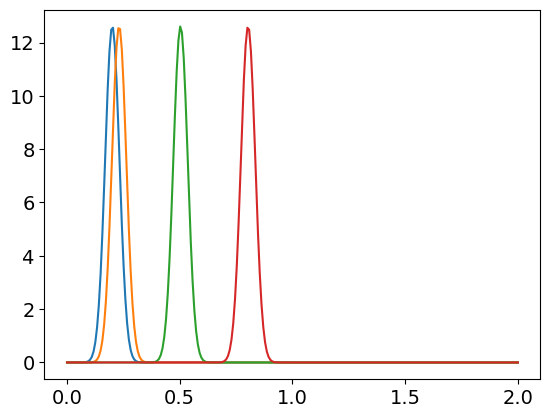

In [32]:
snapshot_matrix = stacked_train_datasets[: CONFIG.Nt].data

plt.figure()
# plt.pcolormesh(TTx, XX, snapshot_matrix.detach(), cmap=mpl.colormaps["magma"])
plt.pcolormesh(TTx, XX, snapshot_matrix.detach())
plt.colorbar()
plt.rc("xtick", labelsize=12)  # fontsize of the tick labels
plt.rc("ytick", labelsize=12)  # fontsize of the tick labels
plt.ylabel("Space", fontsize=16)
plt.xlabel("Time", fontsize=16)
# plt.savefig(results_path / "advection_snapshot.png", bbox_inches='tight')

plt.figure()
plt.semilogy(torch.linalg.svdvals(snapshot_matrix), lw=5)
# plt.semilogy(torch.linalg.svdvals(snapshot_matrix), lw=5, c="magenta")
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.ylabel("Singular value", fontsize=16)
plt.xlabel("Index", fontsize=16)
# plt.savefig(results_path / "advection_singular.png", bbox_inches='tight')


plt.figure()
for k in [0, 10, 100, -1]:
    plt.plot(domain, snapshot_matrix[k])

## Animating the snapshot

Animations are nice, so we make a gif out of the snapshot matrix.

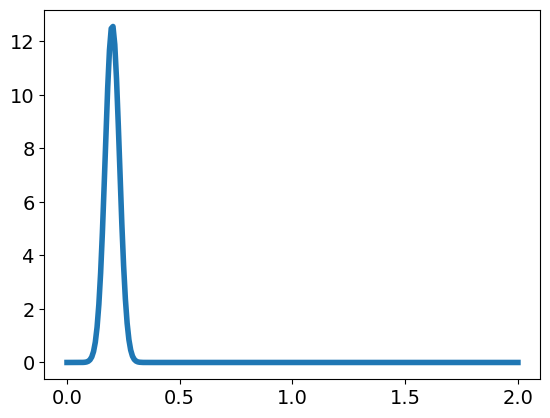

In [33]:
fig = plt.figure()
(line,) = plt.plot(domain, snapshot_matrix.data[0, :].detach(), lw=4)


def animate(k):
    line.set_ydata(snapshot_matrix.data[k, :].detach())
    return (line,)


# ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=CONFIG.Nt)
# ani.save(results_path / "advection.gif", dpi=300, writer=PillowWriter(fps=25))

## POD

The default ROM is POD, so let's see how well this does on this dataset. 

In [34]:
U, S, Vh = torch.linalg.svd(stacked_train_datasets, full_matrices=False)
Sigma = S**2
relative_error = (torch.sum(Sigma, dim=0) - torch.cumsum(Sigma, dim=0)) / torch.sum(Sigma, dim=0)
ldim: int = torch.count_nonzero(relative_error >= 1e-6).item() + 1

Text(0.5, 0, 'Index')

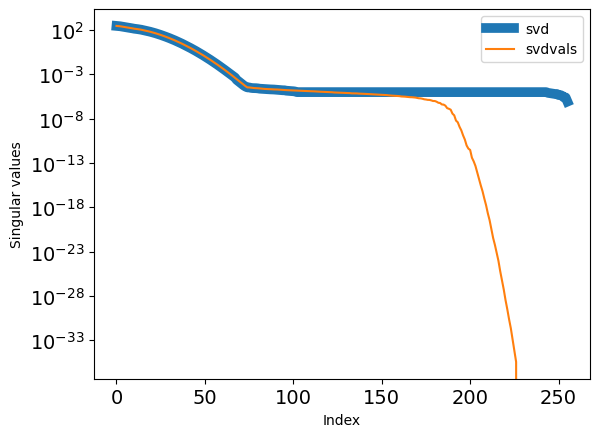

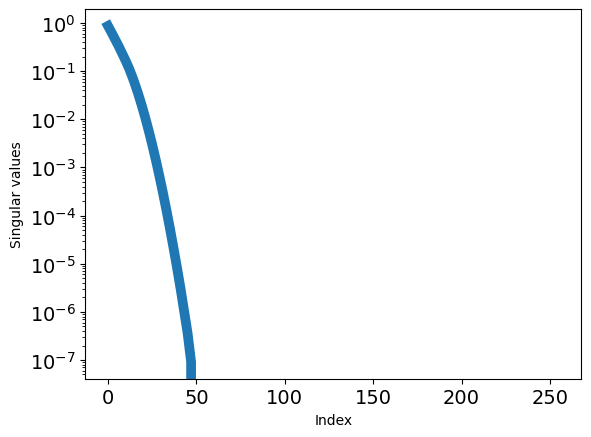

In [36]:
plt.figure()
plt.semilogy(S, lw=7, label="svd")
plt.semilogy(torch.linalg.svdvals(stacked_train_datasets), label="svdvals")
plt.legend(loc="upper right")
plt.ylabel("Singular values")
plt.xlabel("Index")

plt.figure()
plt.semilogy(relative_error, lw=7)
plt.ylabel("Singular values")
plt.xlabel("Index")

Text(0.5, 0, 'index')

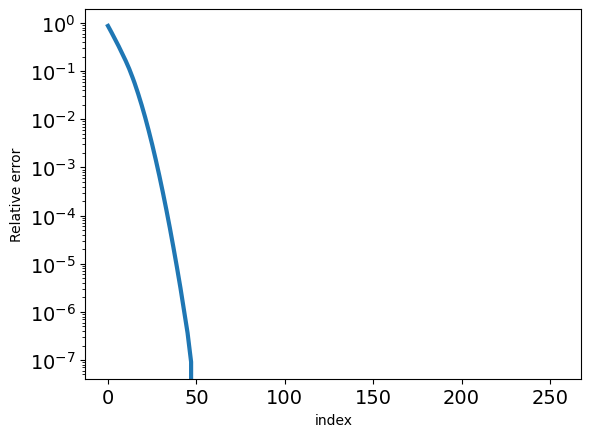

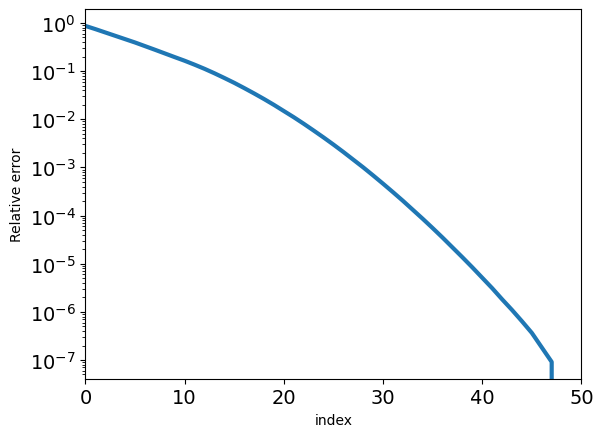

In [43]:
plt.figure()
plt.semilogy(relative_error, lw=3)
plt.ylabel("Relative error")
plt.xlabel("index")


plt.figure()
plt.semilogy(relative_error, lw=3)
plt.xlim((0, 50))
plt.ylabel("Relative error")
plt.xlabel("index")

This shows that the singular values decay relatively slowly and the POD requires many modes. 

In [48]:
print(ldim)
print(torch.count_nonzero(relative_error >= torch.finfo().eps).item() + 1)

45
48


Let's compute the reduced eigenvector matrix.

In [37]:
Vhr = Vh[:ldim, :]

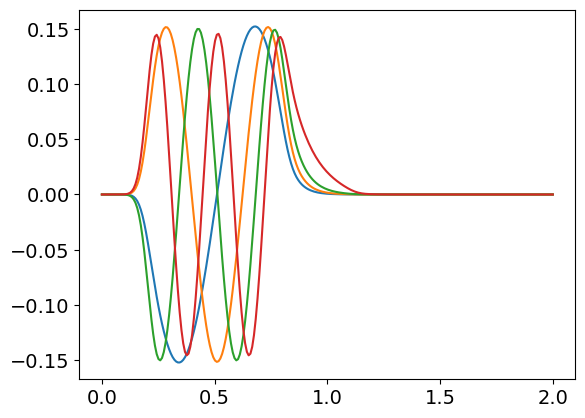

In [38]:
plt.figure()
plt.plot(domain, Vh[1, :], label="mode 1")
plt.plot(domain, Vh[2, :], label="mode 2")
plt.plot(domain, Vh[3, :], label="mode 3")
plt.plot(domain, Vh[4, :], label="mode 4")

We compute now the loss for the POD.

In [51]:
print(
    torch.norm(stacked_train_datasets - torch.einsum("nm,bn->bm", Vhr.T @ Vhr, stacked_train_datasets)) ** 2
    / torch.norm(stacked_train_datasets) ** 2
)

tensor(6.4245e-07)


In [46]:
test_loss_batch = 0.0
test_loss_pod = 0.0

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)

for (batch,) in tqdm(test_loader):
    loss = loss_functional(batch, torch.einsum("nm,bn->bm", Vhr.T @ Vhr, batch))
    test_loss_pod += loss.item()

    batch_loss = loss_functional(batch, torch.zeros_like(batch))
    test_loss_batch += batch_loss.item()

print("Loss (abs): ", test_loss_pod)
print("Loss (rel): ", test_loss_pod / test_loss_batch)

100%|██████████| 4/4 [00:00<00:00, 699.75it/s]

Loss (abs):  1.644193184802134e-05
Loss (rel):  9.215544663072853e-07


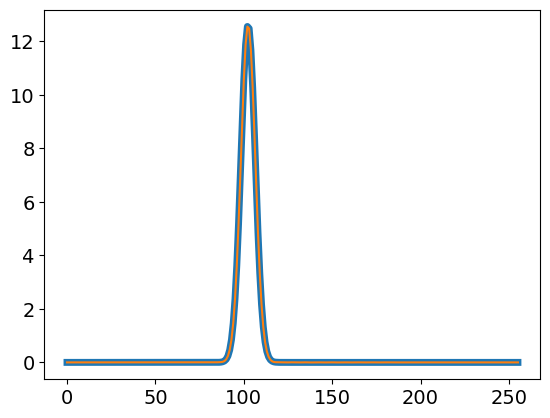

In [49]:
plt.figure()
plt.plot(snapshot_matrix[-1].detach(), lw=5)
plt.plot((Vhr.T @ Vhr @ snapshot_matrix[-1]).detach())